### Trabalho Prático 2 - Aprendizado de Máquinas

#### Aluno: Mauricio de Oliveira
#### Professor: Adriano Veloso
#### Departamento de Ciência da Computação - Universidade Federal de Minas Gerais

### RESUMO

#### Este trabalho prático se refere a implementação da técnica de _boosting_, processo que adiciona diversos classificadores fracos de modo iterativo para construir um classificador forte. O processo de _boosting_ emprega dois mecanismos: ajustes nos pesos de cada classificador e ajustes nos pesos associados a cada entrada. 
#### Os conjuntos de pesos são alterados a cada iteração $t$ do processo. O peso de cada classificador indica a importância deste para classificação binária correta $(+1, -1)$. Assim, o peso $\alpha^t$ de um classificador será alto caso seu erro (_training error_ ou erro empírico) for baixo. Já o ajuste no peso $w_i$ de cada entrada do _training set_ é feito de modo que exemplos classificados incorretamente tenha seu peso aumentado e exemplos com classificação correta tenha o peso diminuído, pois dessa forma, na próxima iteração, será possível dar maior foco aos exemplos incorretos.
#### Sendo assim, o processo iterativo do _boosting_ é o seguinte:

> 1. No início, fazer $w_i^1$ = 1/n, sendo n o tamanho do _training set_ <br>
> 2. Loop: <br>
>> 2.1 Escolha classificador $h_t$ que minimiza erro empírico na iteração t <br>
>> 2.2 Recalcule $\alpha^t$ <br>
>> 2.3 Recalcule $w_i^{t+1} $ <br>
> 3. Parar quando erro empírico convergir. <br>
> 4. O classificador final treinado pelo processo de boosting será dado por:

\begin{equation*}
h(X) = \sum_{t=1} sign(\alpha^t h_t(X))
\end{equation*}

### ESPECIFICAÇÕES

#### Da sequência acima, é preciso definir $h_t$, como é feito o passo 2.2 e 2.3.
#### 1. $h_t$ pode ser qualquer classificador fraco, e neste trabalho será usado [_decision stumps_](https://en.wikipedia.org/wiki/Decision_stump), uma _decision tree_ de profundidade 1. <br> A escolha se baseia no erro empírico de cada _decision stump_ analisado, levando em consideração o peso $w_i$. Assim, um classificador que faz dois erros em entradas cujo pesos são 0.5 e 1, respectivamente, tem erro menor do que um classificador que erra em apenas 1 exemplo, porém com peso 2. 
 
#### 2. O ajuste de $\alpha^t$ (passo 2.2) é feito da seguinte forma:

\begin{equation*}
\alpha^t = \dfrac{1}{2} \log_{} {\dfrac{1-\varepsilon^t}{\varepsilon^t}}
\end{equation*}

#### na qual $\varepsilon^t$ é o erro empírico do modelo na iteração t (que já pode ser calculado logo após passo 2.1)
#### 3. Por último, o ajuste nos pesos dos exemplos para a próxima iteração $w_i^{t+1} $ é dado por:

\begin{equation*}
w_i^{t+1} = w_i^t e^{-\alpha^t h_t y}
\end{equation*}

#### aonde y é o valor correto {+1,-1}. É importante normalizar (dividir pela soma) $w_i^{t+1}$ de modo que $ \sum_{i=1}^n w_i^{t+1} = 1$. Note que dessa forma o passo 2.3 de fato irá elevar o peso dos exemplos incorretos e diminuir dos exemplos corretos. Por exemplo, se $h_t$ está errado, isso significa que $sign(h_t y) = -1$. Assim, $w_i^{t+1}$ será aumentado por um fator de $e^{\alpha^t}$. Caso contrário, $w_i^{t+1}$ será diminuido ao ser multiplicado por $e^{-\alpha^t}$. <br> Obs: essa análise supõe $\alpha^t$ > 0, o que ocorrerá caso $\varepsilon^t < 0.5$, ou seja, nós conseguimos encontrar classificadores fracos mas que ao menos possuem desempenho um pouco melhor que um classificador aleatório.

### IMPLEMENTAÇÃO

In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from timeit import default_timer as timer


Acima, nós importamos bibliotecas padrão para trabalhar com nossos dados. Além disso, algumas funções para simplificar nosso trabalho, como KFold para facilitar no processo de validação cruzada. 

Primeiro, vamos mostrar como implementamos a classe _BestDecisionStump_, responsável por retornar o stump do passo 2.1.

In [2]:
# lê o arquivo tic-tac-toe

data = genfromtxt('tic-tac-toe', delimiter=',', dtype="|U5")

X = data[:,:-1]
Y = data[:,-1]

# converte para valores numéricos

X[X == 'x'] = 1.0
X[X == 'o'] = -1.0
X[X == 'b'] = 0.0
X = X.astype(float)
Y = np.where(Y == 'negat', -1, 1)

Os valores "x" foram transformados em 1 e "o" para -1.0. Os valores que representam espaços em branco passam a ser 0.0. Da mesma forma, Y passou a ser {+1,-1}.
Agora iremos plotar uma gráfico que mostra nossa estratégia para implementar decision stumps.

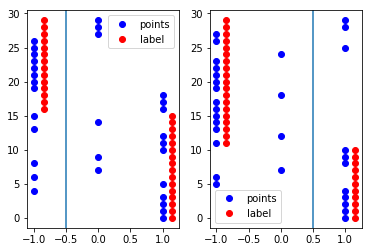

In [3]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.plot(X[610:640,4], range(30),"bo", Y[610:640] + 0.15, range(30), "ro")
plt.legend(["points","label"])
plt.axvline(x = -0.5)
fig.add_subplot(1,2,2)
plt.plot(X[615:645,6], range(30),"bo", Y[615:645] + 0.15, range(30), "ro")
plt.axvline(x = 0.5)
plt.legend(["points","label"])

A imagem acima representa os valores de 30 entradas distinas em uma respectiva coluna, isto é, o valor dentro de um quadro em 30 jogos diferentes, e o respectivo ganhador em vermelho. (-1 = "o", 0 = "b", +1 = "x", -1 = "negative", +1 = "positive")

No espaço das variáveis do jogo tic-tac-toe, existem algumas regiões aonde é possível separar os pontos, porém nós utilizaremos duas: entre "o" e "b" (-1 e 0) ou "b" e "x" (0 e 1). Sendo assim, definimos duas _boundaries_ que servirá como nossos _splits_ (existem outras formas, no entanto):

1. Classificar como +1 os pontos > -0.5 e -1 os pontos < -0.5
2. Classificar como +1 os pontos > 0.5 e -1 os pontos < 0.5

O split ideal deverá minimizar o erro, que é calculado usando o peso da entrada. Dessa forma, a cada iteração do processo de boosting, nós investigamos um total de **18** splits, 2 para cada coluna. Contanto que exista pelo menos um com erro menor que 0.5, devemos conseguir formar um bom _ensemble_.

Segue então a definição da classe _BestDecisionStump_.

In [4]:
class BestDecisionStump():
    
    """ Fits data to best decision stumps considering x, y and w."""
    
    def __init__(self, x, y, w, 
                 num_cols = 9, split_values = [-0.5, 0.5]):
        
        """Initializes the decision stump ."""
    
        self.x = x
        self.y = y
        self.w = w
        self.split_values = split_values
        self.num_cols = num_cols
        
    def fit(self):
        
        " Returns the best stump available, considering x, y and w. "
        
        stump = np.zeros((self.num_cols * 2, 1))
            
        for num_col in range(self.num_cols):
             
            # calculates two stumps
            # (positive number) - (-negative number) = positive number

            w_label = self.w*self.y
            stump[num_col] =  w_label[self.x[:,num_col] > self.split_values[0]].sum() 
            stump[num_col] -= w_label[self.x[:,num_col] < self.split_values[0]].sum() 
            stump[self.num_cols + num_col] =  w_label[self.x[:,num_col] > self.split_values[1]].sum() 
            stump[self.num_cols + num_col] -= w_label[self.x[:,num_col] < self.split_values[1]].sum() 
                     
        self.best_stump = {"stump_perf": stump.max(), 
                           "col": np.argmax(stump),
                           "split": self.split_values[0] 
                                    if np.argmax(stump) <= self.num_cols-1 
                                    else self.split_values[1]}
        
        return self.best_stump
    
    def predict(self):
        
        "Must be called after fit."
        
        self.pred = np.zeros(self.y.shape[0])
        
        i = 0
        
        for x in self.x[:,self.best_stump["col"]%9]:
            
            if float(x) > self.best_stump["split"]:
                self.pred[i] = 1.0
            else:
                self.pred[i] = -1.0
            
            i+=1
            
        assert(self.pred.shape == self.y.shape)
        return self.pred
    
    def calculate_error(self):
        
        "Must be called after fit and predit."
        
        return self.w.dot(self.pred != self.y)

O método mais importante é _fit_, que compara 18 stumps e retorna o mais apropriado. O cálculo, como podem ver, maximiza predições corretas levando em consideração o peso. 

Também iremos criar uma função separada que permite fazer a predição.

In [5]:
def make_prediction(stump, x):
    
    pred = np.zeros(x.shape[0])
        
    i = 0
        
    for value in x[:,stump["col"]%9]:
    
        if float(value) > stump["split"]:
            pred[i] = 1.0
        else:
            pred[i] = -1.0
            
        i+=1
        
    return pred

Assim estamo prontos para o treino. 
Criando os sets para treino:


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

Agora definiremos a função que utilizará a classe para realizar o processo de _boosting_, no qual deve-se apenas ser passado.

In [7]:
def get_scores(total_iter):
    
    """ Returns train, test, validation and average 
        stump error after total_iter iterations. """

    hypotheses   = dict()
    stumps_error = dict()

    ensemble_error = 0
    validation_error = 0
    training_error = 0
    stump_overall_error = 0

    kf = KFold(n_splits = 5)
    k = 0

    for train_index, val_index in kf.split(X_train):      
    
        N = len(train_index)
        w = np.ones(N) / N
    
        for it in range(total_iter):
        
            x_train, x_val = X_train[train_index], X_train[val_index]
            y_train, y_val = Y_train[train_index], Y_train[val_index]

            h = BestDecisionStump(x_train, y_train, w)
            h.fit()
            pred  = h.predict()
            error = h.calculate_error()
            alpha = (np.log((1 - error)/error)) / 2
            stumps_error[it] = {"error":error,"alpha":alpha}

            w = w * np.exp(- alpha * y_train * pred)
            w = w / w.sum()
    
            hypotheses[it] = {"function":h.best_stump, "weight":alpha}

        #average stump error
        stump_error = 0
        alpha_sum = 0
        for it in stumps_error:
            alpha_sum += stumps_error[it]["alpha"]
            stump_error += stumps_error[it]["error"]*stumps_error[it]["alpha"]
        stump_error /= alpha_sum    
        stump_overall_error += stump_error
    
        #training error
        y = np.zeros(x_train.shape[0])
        for it in hypotheses:
            y = y + (hypotheses[it]["weight"] * make_prediction(hypotheses[it]["function"], x_train))
        y = np.sign(y)
        training_error += 1 - accuracy_score(y,y_train)    
    
        #validation error
        y = np.zeros(x_val.shape[0])
        for it in hypotheses:
            y = y + (hypotheses[it]["weight"] * make_prediction(hypotheses[it]["function"], x_val))
        y = np.sign(y)
        validation_error += 1 - accuracy_score(y,y_val)  
    
        #test error
        y = np.zeros(X_test.shape[0])
        for it in hypotheses:
            y = y + (hypotheses[it]["weight"] * make_prediction(hypotheses[it]["function"], X_test))
        y = np.sign(y)
        ensemble_error += 1 - accuracy_score(y,Y_test)  
    
        k+=1
    
    return(training_error/k, validation_error/k, 
           ensemble_error/k, stump_overall_error/k)

No corpo da função encontra-se a implementação da sequência 2.1 - 2.3.

2.1: <br>
h = BestDecisionStump(x_train, y_train, w) <br>
h.fit() <br>

2.2: <br>
pred  = h.predict() <br>
error = h.calculate_error() <br>
alpha = (np.log((1 - error)/error)) / 2 <br>

2.3: <br>
w = w * np.exp(- alpha * y_train * pred) <br>
w = w / w.sum() <br>

Após isso, o cálculo de todos os erros: treino, validação, teste e média dos stumps calculados para um determinado valor de iterações 5 vezes cada. Com isso, vamos analisar estes erros.

total time:  201.0715762510008


Text(0,0.5,'Erro')

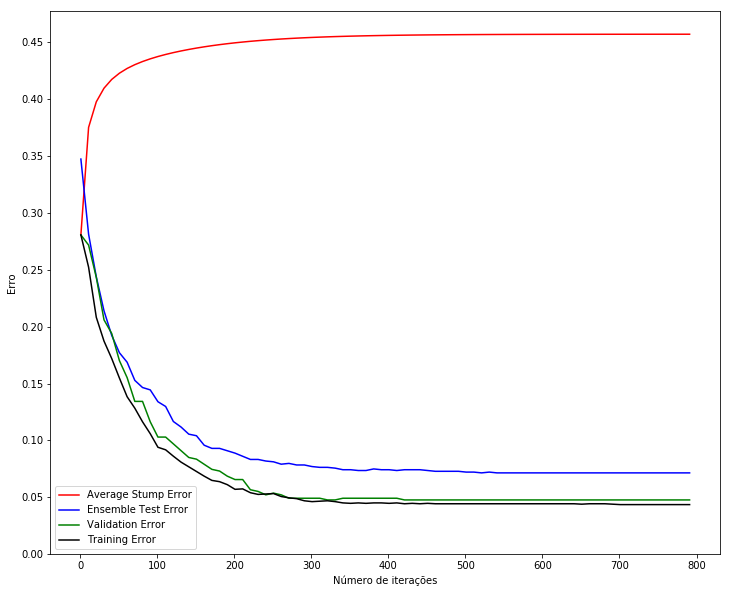

In [9]:
train_error    = dict()
val_error      = dict()
stump_error    = dict()
test_error     = dict()
    
start = timer()

for n_iter in range(1,800,10):
    
    (e1,e2,e3,e4) = get_scores(n_iter)
    train_error[n_iter]    = e1
    val_error[n_iter]      = e2  
    test_error[n_iter]     = e3  
    stump_error[n_iter]    = e4  

print("total time: ", timer() - start)

fig = plt.figure(figsize=(12, 10))

plt.plot(stump_error.keys(), stump_error.values(), color = 'r')
plt.plot(test_error.keys(), test_error.values(), color = 'b')
plt.plot(val_error.keys(), val_error.values(), color = 'g')
plt.plot(train_error.keys(), train_error.values(), color = 'k')

plt.yticks(np.arange(0, 0.5, step=0.05))
plt.legend(["Average Stump Error","Ensemble Test Error",
            "Validation Error", "Training Error"])
plt.xlabel("Número de iterações")
plt.ylabel("Erro")

O número de iterações representa exatamente o número de classificadores fracos no _ensemble_. Assim, vemos que um conjunto de classificadores fracos é sim capaz de formar um classificador forte. A cada classificador adicionado, melhor os erros (teste, treino e validação). 

Primeiro, vemos que o _average stump error_, isto é, o erro médio ponderado de cada classificador fraco tende a 0.5 e o erro de um único classificador (número de iterações = 1) é melhor que o erro em dados não vistos (_ensemble test error_). Isso mostra que fica "cada vez mais difícil" encontrar stumps com desempenho pouco melhor que um classificador aleatório, a medida que os pesos w se alteram.

Um dos objetivos principais em se usar classificadores fracos é "herdar" suas características de pouco _overfit_. Como não existe um intervalo grande entre valores de erro de treino (_training error_) e de teste (_ensemble test error_), vemos que de fato o _ensemble_ possui pouca variância.

Além disso, vemos erro de validação generaliza bem, pois é próximo ao erro no teste.

---